In [120]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import numpy as np
import pickle

In [121]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Parameters

In [122]:
batch_size = 1000

num_classes = 43
in_channels = 3

epoch = 10
weight_decay = 1e-5
lr = 1e-3

difusion_steps = 500

### Transforms

In [123]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda t: (t * 2) - 1)
])

# reverse_transform = transforms.Lambda(lambda t: (t + 1) / 2) # used to denormalize

### Dataset

In [124]:
full_DS = ImageFolder(root="trafic_32", transform=transform)
full_loader = DataLoader(dataset=full_DS, pin_memory=True, num_workers=0, shuffle=True, batch_size=batch_size)

len(full_DS)

39209

In [125]:
# classes_elem_cnt = {}
# for i in range(len(full_DS)):

#     x = full_DS[i][1]

#     if (x in classes_elem_cnt.keys()):
#         classes_elem_cnt[x] += 1

#     else:
#         classes_elem_cnt[x] = 1

#     # if (i%10==0):
# print(classes_elem_cnt)

# with open('classes_member_cnt.pkl', 'wb') as file:
#     pickle.dump(classes_elem_cnt, file)


In [126]:
with open('classes_member_cnt.pkl', 'rb') as file:
    pickle.load(file)

### Model + U-Net block

In [127]:
class Unet_Block(nn.Module):
    """
    Base U-Net block
    in_channels - number of input channels
    out_channels - number of out channels
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.activation = nn.SiLU()

        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.BatchNorm2d(out_channels) # to moze na GN zmienic
        ])

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [128]:
class Rescaler(nn.Module):
    """
    Resacler; either upscales given input or downscales it (size x2 or /2 only)
    """

    def __init__(self, in_channels, out_channels, upscale:bool):
        super().__init__()

        ######
        self.activation = nn.SiLU()
        ######

        if upscale:
            self.rescaler = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))
        else:
            self.rescaler = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))

    def forward(self, x):
        return self.activation(self.rescaler(x))

In [129]:
class U_Net(nn.Module):

    def __init__(self, in_channels, num_classes, embedding_classes_dim, embedding_noise_dim):
        super().__init__()

        self.num_classes = num_classes
        self.embedding_dim = embedding_classes_dim
        self.class_embedding = nn.Embedding(num_classes, embedding_classes_dim) #

        self.embedding_noise_dim = embedding_noise_dim
        self.embedding_noise = nn.Linear(1, embedding_noise_dim) # linear, bo noise_level sa z przestrzeni ciągłej -1,1 --> inf num classes

        self.encoder = nn.ModuleList([

            Unet_Block(in_channels + embedding_classes_dim + embedding_noise_dim, 32),
            Rescaler(32, 32, upscale=False), # 16x16

            Unet_Block(32, 64),
            Rescaler(64, 64, upscale=False), #8x8

            Unet_Block(64, 128),
            Rescaler(128, 128, upscale=False), #4x4

            Unet_Block(128, 172),
            Rescaler(172, 172, upscale=False), # 2x2
        ])

        self.latent = nn.Sequential(
            nn.Conv2d(in_channels=172, out_channels=226, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=226, out_channels=226, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.BatchNorm2d(226)
        )

        self.decoder = nn.ModuleList([

            Rescaler(226, 226, upscale=True), # 4x4
            Unet_Block(398, 172), # 226 + 172(res)

            Rescaler(172, 172, upscale=True), #8x8
            Unet_Block(300, 128), #(172 + 128)

            Rescaler(128, 128, upscale=True), #16x16
            Unet_Block(192, 64), #(128 + 64)

            Rescaler(64, 64, upscale=True), # 32x32
            Unet_Block(96, 32), #(64 + 32)

            nn.Conv2d(in_channels=32, out_channels=in_channels, kernel_size=1, stride=1, padding=0)

        ])

    def forward(self, x, class_label, noise_amount):  # opcjonalnie dodac noise amount
        residual = []

        # class conditioning + noise conditioning
        class_embedding = self.class_embedding(class_label).unsqueeze(2).unsqueeze(3)
        class_embedding = class_embedding.expand(-1, -1, x.shape[2], x.shape[3])

        noise_embedding = self.embedding_noise(noise_amount.view(-1, 1)).unsqueeze(2).unsqueeze(3)
        noise_embedding = noise_embedding.expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, class_embedding, noise_embedding], dim=1)

        # encoder
        for idx, layer in enumerate(self.encoder):
            x = layer(x)

            if(idx%2 == 0):
                residual.append(x)
        residual.reverse()

        # latent
        x = self.latent(x)

        # decoder
        for idx, layer in enumerate(self.decoder):
            x = layer(x)

            if(idx%2 == 0 and idx <= 6): # idx<=6, bo na idx=8 jest convm, ktory nie dostaje rezyduala
                x = torch.cat([x, residual[int(idx/2)]], dim=1) # (B, CH, H, W) - dim=1

        return x

In [130]:
model = U_Net(in_channels, num_classes, embedding_classes_dim=3, embedding_noise_dim=3)
model = U_Net(in_channels, num_classes, embedding_classes_dim=1, embedding_noise_dim=1)
model.to(device)

U_Net(
  (class_embedding): Embedding(43, 3)
  (embedding_noise): Linear(in_features=1, out_features=3, bias=True)
  (encoder): ModuleList(
    (0): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Rescaler(
      (activation): SiLU()
      (rescaler): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [131]:
# model = U_Net(in_channels, num_classes, 3, 3)
# inputs = torch.randn(8, 3, 32, 32)
# labels = torch.tensor([1,1,3,4,5,6,7,8])
# noise = torch.tensor([.2, .4, .4, .5, .6, .8, .1, .001])
# outputs = model(inputs, labels, noise)
# print(outputs.shape)  # Should print (8, 3, 32, 32)

In [132]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

3736160

In [133]:
optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
loss_fn = nn.MSELoss()

### Image corrupting fnc

In [134]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x) # to zmienic na randn_like - rozkłąd gaussa + dodac resize obrazkó do -1,1
    amount = amount.view(-1, 1, 1, 1)  # Ensure shape compatibility for broadcasting
    return x * (1 - amount) + noise * amount


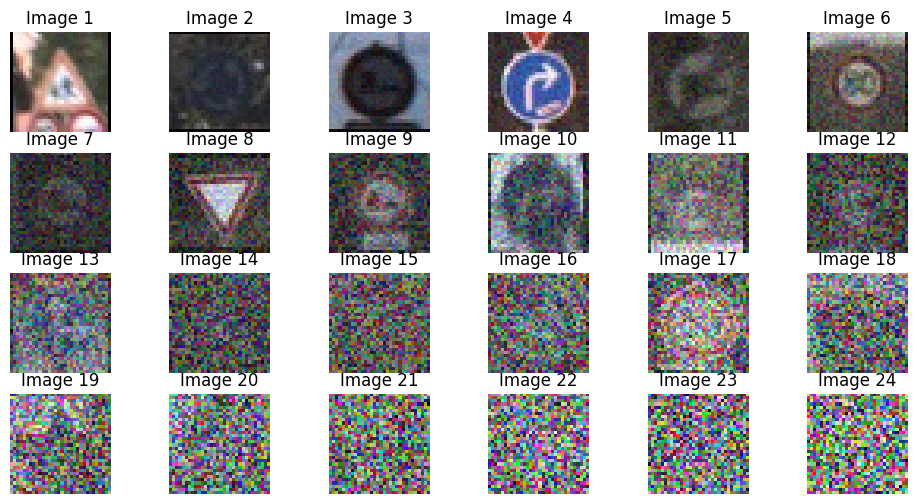

In [135]:
img, y = next(iter(full_loader))
img = img[:24, :,:,:]
x=img

amount = torch.linspace(0, 1, x.shape[0])
x = corrupt(x, amount)
x = x.detach().cpu().numpy()
# x = reverse_transform(x)

fig, axes = plt.subplots(4, 6, figsize=(12, 6))
for i in range(4):
    for j in range(6):
        index = i * 6 + j
        axes[i, j].imshow(x[index].transpose(1, 2, 0).clip(0, 1))
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Image {index + 1}')

plt.show()

### Train function

In [136]:
def train(model, loader, epoch):
    model.train()
    losses = []

    for epoch in range(epoch):

        for x, y in loader:

            x = x.to(device)
            y = y.to(device)

            noise_amount = torch.rand(x.shape[0]).to(device)
            noisy_x = corrupt(x, noise_amount)

            # Get the model prediction
            pred = model(noisy_x, y, noise_amount)

            # Calculate the loss
            loss = loss_fn(pred, x)

            # Backprop and update the params:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(full_loader) :]) / len(full_loader)
        print(f"Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss:05f}")

    model.eval()
    return losses

In [137]:
losses = train(model, full_loader, epoch)
torch.save(model.state_dict(), f="U_net_test.pt")

Finished epoch 1. Average loss for this epoch: 0.142256
Finished epoch 2. Average loss for this epoch: 0.055922
Finished epoch 3. Average loss for this epoch: 0.030076
Finished epoch 4. Average loss for this epoch: 0.020307
Finished epoch 5. Average loss for this epoch: 0.018381
Finished epoch 6. Average loss for this epoch: 0.016952
Finished epoch 7. Average loss for this epoch: 0.016204
Finished epoch 8. Average loss for this epoch: 0.014983


In [ ]:
# model.load_state_dict(torch.load("Current_first_collab_100ep_in_progress.pt"))

<All keys matched successfully>

In [ ]:
asddas

NameError: name 'asddas' is not defined

### Learning curve

(0.0, 0.5)

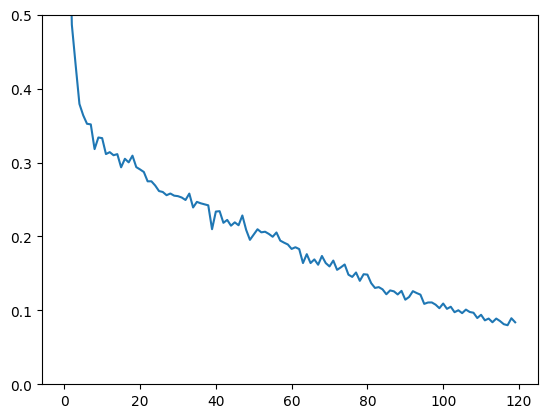

In [ ]:
plt.plot(losses)
plt.ylim(0, 0.5)

### Model predictions (Model is predicting fully-denoised image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


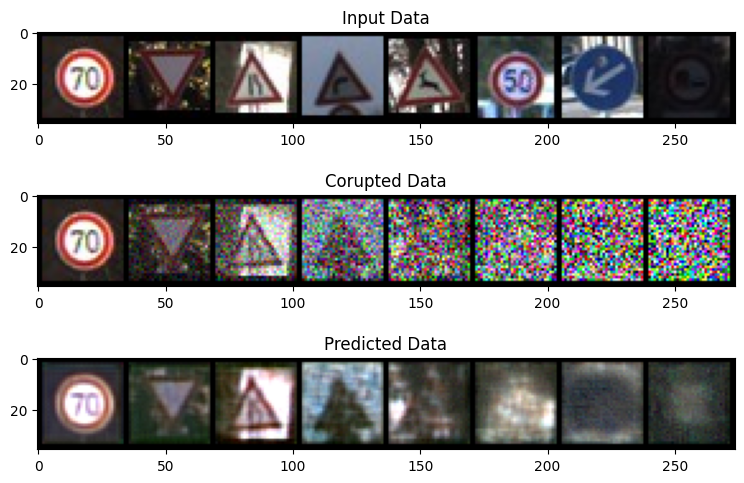

In [ ]:
img, y = next(iter(full_loader))
x = img[:8, :,:,:]
img_classes = y[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)
noised_x = noised_x.detach().cpu()

with torch.no_grad():
    preds = model(noised_x.to(device), img_classes.to(device), amount.to(device)).detach().cpu()

# x = reverse_transform(x)
# noised_x = reverse_transform(noised_x)
# preds = reverse_transform(preds)

fig, axs = plt.subplots(3, 1, figsize=(9, 6))
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(x, nrow=8, padding=2).permute(1, 2, 0))

axs[1].set_title("Corupted Data")
axs[1].imshow(torchvision.utils.make_grid(noised_x, nrow=8, padding=2).permute(1, 2, 0))

axs[2].set_title("Predicted Data")
axs[2].imshow(torchvision.utils.make_grid(preds, nrow=8, padding=2).permute(1, 2, 0))

plt.show()

### Difusion

In [ ]:
def mix_factor_calc(step, tau):
    return np.exp(-step/tau)

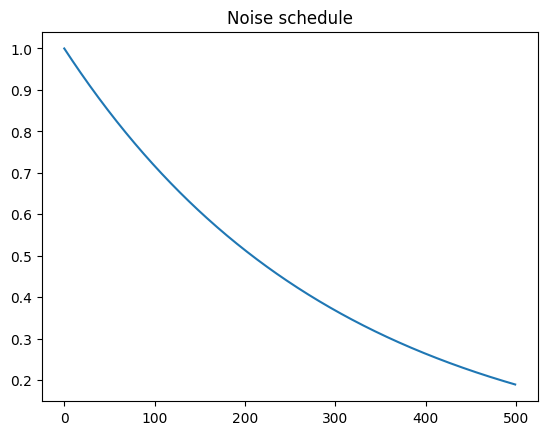

In [ ]:
tau = 300

x = np.linspace(0, difusion_steps-1, difusion_steps)
y = mix_factor_calc(x, tau)

plt.title("Noise schedule")
plt.plot(x, y)

In [ ]:
def difusion(steps, image_num, tau):

    x = torch.randn(image_num, 3, 32, 32).to(device)
    pred_output_history = []
    step_history = [x.detach().cpu()]

    classes_idx = torch.randint(0, num_classes, size=(image_num, )).to(device)
    # classes_idx = torch.tensor([1,2,3,4,5,6,7,8]).to(device)
    print(classes_idx)
    mix_factor = torch.ones(image_num).to(device)
    print(mix_factor)

    for step in range(steps):
        with torch.no_grad():
            pred = model(x, classes_idx, mix_factor)

        pred_output_history.append(pred.detach().cpu())

        mix_factor = torch.tensor(mix_factor_calc(step, tau))

        # mix_factor = torch.tensor([1/(steps - step)]).to(device) # Linear
        x = x*(1-mix_factor) + pred*mix_factor
        mix_factor = torch.ones(image_num).to(device) * mix_factor

        step_history.append(x.detach().cpu())

    return pred_output_history, step_history


In [ ]:
pred_h, step_h = difusion(steps=difusion_steps, image_num=8, tau=tau)

tensor([20, 38, 39, 23, 31, 37, 15, 27], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(100, 100))
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')

j=0
for i in range(difusion_steps):
    if (i%100 == 0):
        axs[j, 0].imshow(torchvision.utils.make_grid(reverse_transform(step_h[i]), padding=2).permute(1, 2, 0))
        axs[j, 1].imshow(torchvision.utils.make_grid(reverse_transform(pred_h[i]), padding=2).permute(1, 2, 0))
        j+=1

axs[5, 0].imshow(torchvision.utils.make_grid(reverse_transform(step_h[difusion_steps-1]), padding=2).permute(1, 2, 0))
axs[5, 1].imshow(torchvision.utils.make_grid(reverse_transform(pred_h[difusion_steps-1]), padding=2).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i